# Matrix Factorisation - Linear & Non-Negative

In [26]:
from importlib import reload
import utils
reload(utils)

<module 'utils' from '/Users/amitkaps/Documents/github/recommendation/MovieLens/utils.py'>

In [3]:
import keras
print(keras.__version__)

2.2.5


In [335]:
import numpy as np
import pandas as pd
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
%matplotlib inline

In [6]:
ratings = pd.read_csv("data/ratings.csv")

## Prepare the data

In [7]:
from utils import random_split, encode_user_item

In [180]:
# Create unique user & item index
encoded_interaction, n_users, n_items = encode_user_item(ratings, "user_id", "movie_id")

Number of users:  943
Number of items:  1682


In [184]:
max_rating = encoded_interaction.rating.max()
min_rating = encoded_interaction.rating.min()
min_rating, max_rating

(1, 5)

In [181]:
# Data Splitting
train, val, test = random_split(encoded_interaction, [0.6, 0.2, 0.2])

In [10]:
train.shape, val.shape, test.shape

((60000, 6), (20000, 6), (20000, 6))

In [39]:
train.head()

,user_id,movie_id,rating,unix_timestamp,user_index,item_index
42699,566,384,3,881651360,565,383
96341,500,402,3,883875388,499,401
93875,719,510,4,879360493,718,509
57248,823,48,5,878438642,822,47
65944,708,9,1,877325135,707,8


## Model #1: Explicit Matrix Factorisation => Embedding Dot Product

In [322]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils.vis_utils import model_to_dot
import vis

In [285]:
l2?

Object `l2` not found.


In [341]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [337]:
n_factors = 40
model_mf = ExplicitMF(n_users, n_items, n_latent_factors)

In [338]:
model_mf.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
___________________________________________________________________________________________

In [339]:
%%time
output_mf = model_mf.fit([train.user_index, train.item_index], train.rating, batch_size=128, epochs=5, verbose=1,
                        validation_data=([val.user_index, val.item_index], val.rating))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 92us/step - loss: 13.2711 - val_loss: 10.6311
Epoch 2/5
60000/60000 [==============================] - 2s 39us/step - loss: 4.7422 - val_loss: 1.9116
Epoch 3/5
60000/60000 [==============================] - 2s 42us/step - loss: 1.4049 - val_loss: 1.2080
Epoch 4/5
60000/60000 [==============================] - 2s 35us/step - loss: 1.0407 - val_loss: 1.0426
Epoch 5/5
60000/60000 [==============================] - 2s 42us/step - loss: 0.9312 - val_loss: 0.9801
CPU times: user 18.4 s, sys: 1.87 s, total: 20.2 s
Wall time: 16.1 s


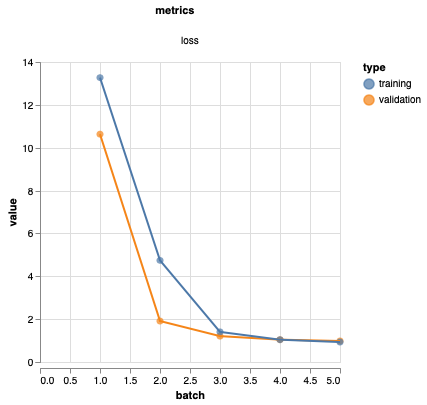

In [340]:
vis.metrics(output_mf.history)

In [334]:
score = model_mf.evaluate([test.user_index, test.item_index], test.rating, verbose=1)
score

20000/20000 [==============================] - 10s 477us/step


13.734379481506348

In [330]:
def plot_item_embedding(model):
    item_embedding = model.get_layer(name='ItemEmbedding').get_weights()[0]
    f, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(item_embedding_mf_df, ax=ax);

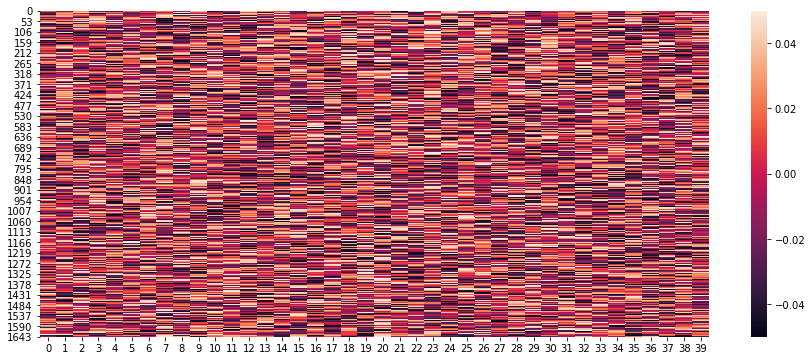

In [331]:
plot_item_embedding(model_mf)

## Model #2: Explicit Matrix Factorisation with Bias => Embedding Dot Product with Bias

In [344]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-5), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [345]:
n_factors = 40
model_mf_bias = Explicit_MF_Bias(n_users, n_items, n_factors)

In [346]:
model_mf_bias.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
___________________________________________________________________________________________

In [347]:
%%time
output_mf_bias = model_mf_bias.fit([train.user_index, train.item_index], train.rating, batch_size=64, epochs=5, verbose=1,
                        validation_data=([val.user_index, val.item_index], val.rating))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 141us/step - loss: 1.3431 - val_loss: 1.0957
Epoch 2/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.9508 - val_loss: 0.9234
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.8100 - val_loss: 0.8837
Epoch 4/5
60000/60000 [==============================] - 4s 66us/step - loss: 0.7189 - val_loss: 0.8741
Epoch 5/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.6426 - val_loss: 0.8773
CPU times: user 34.6 s, sys: 2.9 s, total: 37.5 s
Wall time: 25.9 s


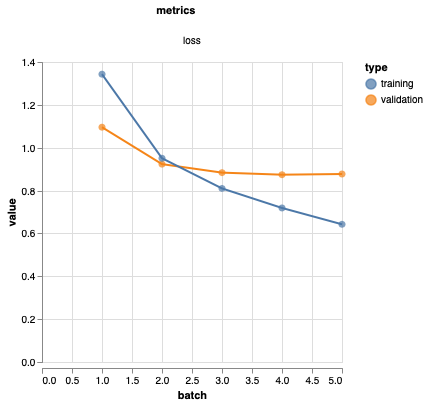

In [348]:
vis.metrics(output_mf_bias.history)

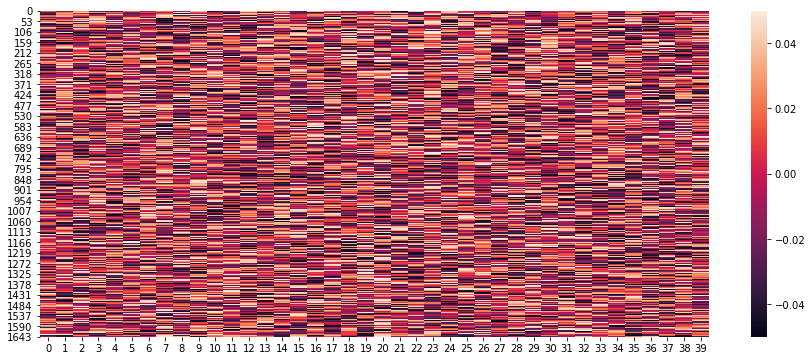

In [349]:
plot_item_embedding(model_mf_bias)

## Non-Negative Matrix Factorisation

In [353]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5),
                               embeddings_constraint= non_neg(),
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-5), 
                               embeddings_constraint= non_neg(),
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [354]:
n_factors = 40
model_nnmf_bias = Explicit_MF_Bias(n_users, n_items, n_factors)

In [355]:
%%time
output_nnmf_bias = model_nnmf_bias.fit([train.user_index, train.item_index], train.rating, batch_size=64, epochs=5, verbose=1,
                        validation_data=([val.user_index, val.item_index], val.rating))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 109us/step - loss: 1.1830 - val_loss: 0.9838
Epoch 2/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.9398 - val_loss: 0.9422
Epoch 3/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.9018 - val_loss: 0.9267
Epoch 4/5
60000/60000 [==============================] - 5s 75us/step - loss: 0.8805 - val_loss: 0.9171
Epoch 5/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.8632 - val_loss: 0.9090
CPU times: user 37.2 s, sys: 4.56 s, total: 41.8 s
Wall time: 29 s


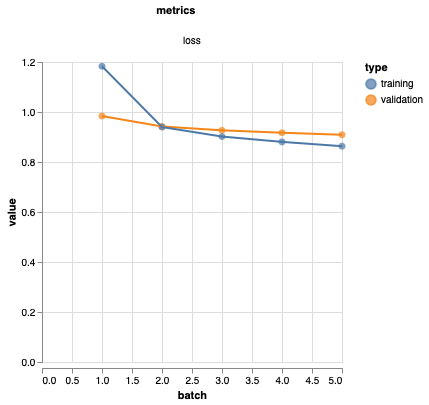

In [356]:
vis.metrics(output_nnmf_bias.history)

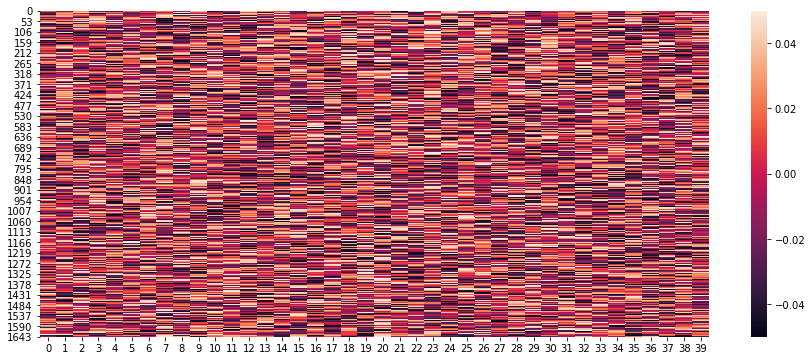

In [357]:
plot_item_embedding(model_nnmf_bias)